# House-Cleaning: Getting rid of outliers I

Working with real-world data presents many challenges that sanitized text book data doesn't have. One of them is how to handle outlier. Outliers are defined as points that differ significantly from other data points and they are especially common in data obtained through manual input processes.  <br>
For example, on an online listing site, someone might accidentally pressed the zero-key a bit too often and suddenly the small rental flat is as expensive as a palace. While it is obvious in this example that the recorded data does not represent the real world, other outliers can be more tricky. What is for example with the old villa in a small town offered for 1€? It might be one of these run-down houses in a dying town and thus could be the actual offering price.

Very roughly we can say that there are two categories of outliers:

- Outliers that don't represent a real observation, but instead result from an error or mistake. I'll call them "proper outlier".
- Outliers that do represent a real observation, but look extremely different compared to other data. I'll call them "improper outlier".

Deciding which type of outlier one is dealing with can be difficult and one usually needs to check the context. Ideally, you'll only want to discard "proper outliers" and keep the improper ones. However, both types of outlier can be problematic for any subsequent analysis or modelling. In this post, I will mostly focus on identifying outliers in general and won't talk too much about distinguishing between the two. Nevertheless, I highly recommend you to always check what type of outlier you're dealing with and to determine the cause of the outlier.
But now let's talk about how to identify outliers.

A year ago, I [scraped](/2018/scraping-the-web-or-how-to-find-a-flat) some [rental offers](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) and except for throwing away some duplicates, this is still very much the raw data and thus still has a bunch of outliers.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 200

blue = "#008fd5"
red = "#fc4f30"

In [2]:
plt.style.use('corrie')

In [3]:
d = pd.read_csv("/home/corrie/Documents/Projects/immoscout/data/immo_data_feb_2020.csv")
d["totalRent"] = np.where((d["totalRent"].isnull()) | (d["totalRent"] == 0),
                          np.where( d["serviceCharge"].notnull(), d["baseRent"] + d["serviceCharge"], d["baseRent"]),
                          d["totalRent"])

This can most easily be seen when we try to plot it. Let's look at the total rent versus the living space:


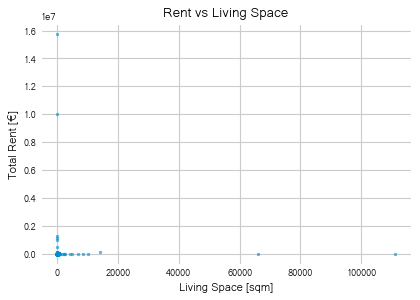

In [4]:
fig, ax = plt.subplots(dpi=80)
sc = ax.scatter(d["livingSpace"],d["totalRent"], s=6, alpha=0.6)

ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_title("Rent vs Living Space")
plt.show()

Does this plot remind you of all the times you wanted to have a quick look at your data, see if there's any interesting pattern or some insight to be gained just to then be reminded of the fact that your data is still dirty? It definitely does for me. <br>
There are some flats that are larger than 10,000 sqm which, according to [the Measure of Things](https://www.bluebulbprojects.com/MeasureOfThings/results.php?comp=area&unit=m2&amt=10000&sort=pr&p=1) is twice as big as Bill Gate's home. And that place with a rent of 10 million? Doesn't look right.

One way to get a nicer plot (and discard some outliers), is to just eyeball the axes, use whatever knowledge you have about rents and flats and pick some threshold above or below you'll discard the data:


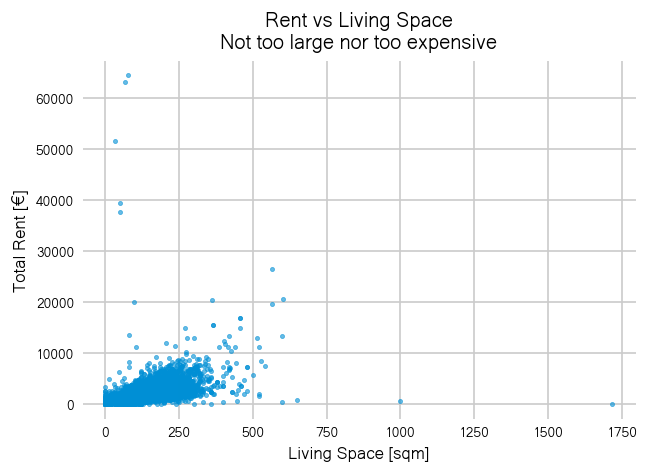

In [5]:
too_large = d["livingSpace"] > 2000
too_expensive = d["totalRent"] > 1e5
alrightish = ~too_large & ~too_expensive
fig, ax = plt.subplots(dpi=120)
sc = ax.scatter(d["livingSpace"][alrightish],
                d["totalRent"][alrightish], 
                    s=6, alpha=0.6)

ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_title("Rent vs Living Space\nNot too large nor too expensive")
plt.show()

It looks better than before but still not great. One could iteratively try smaller thresholds until the blob in the bottom left covers most of the plot area. That's a valid way to obtain reasonable thresholds but might not be very feasible if you have more than two variables and it's also not quite satisfying if you like to automate stuff. <br>
In this post, I will describe a simple methods to identify outliers:

The interquartile range rule which you might remember from your statistics classes (that is, if you had some).

## Interquartile Range Rule
[Quartiles](https://en.wikipedia.org/wiki/Quartile) are important summary statistics of any continuous data. There are three quartiles, $Q_1$, $Q_2$ and $Q_3$, which are the 25th, 50th (the median) and 75th percentiles. The interquartile range $IQR$ is the difference between the first and third quartile: 
$$IQR = Q_3 - Q_1$$ 
The interquartile range thus covers half of the data which is also why they're used for box plots: the boxy part is exactly the interquartile range. 

A good rule of thumb is to say that every point above $Q_3 +1.5 IQR$ or below $Q_1 - 1.5 IQR$ is an outlier.
In python, we can compute this as follows:


In [6]:
def iqr(data):
    """compute the interquartile range (excluding nan)"""
    return np.nanquantile(data, 0.75) - np.nanquantile(data, 0.25)

def iqr_rule(data, factor=1.5):
    """returns an outlier filter mask using the iqr rule"""
    iqr_ = iqr(data)
    upper_fence = np.nanquantile(data, 0.75) + factor*iqr_
    lower_fence = np.nanquantile(data, 0.25) - factor*iqr_
    return (data <= upper_fence) & (data >= lower_fence)

After applying the IQR rule to both our variables, the plot from above looks like this:


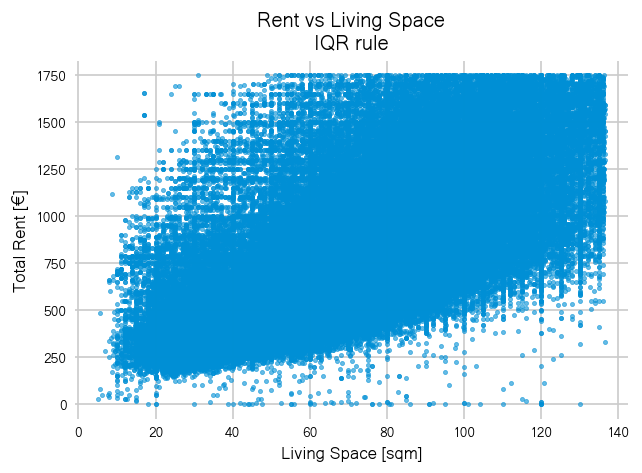

In [7]:
alrightish = iqr_rule(d["livingSpace"]) & iqr_rule(d["totalRent"])
fig, ax = plt.subplots(dpi=120)
sc = ax.scatter(d["livingSpace"][alrightish],
                d["totalRent"][alrightish], 
                    s=6, alpha=0.6)

ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_title("Rent vs Living Space\nIQR rule")
plt.show()

Nice! The blob now covers the whole plot area and we get a much better view of the largest chunk of the data. <br>
However, there is a hard, rectangular edge. It looks like we cut off the data too generously and a considerable part of the data has been discarded because they're either larger than 140sqm or more expensive than 1750€ per month. And while I personally don't see myself renting a flat this expensive in Berlin, it still sounds like very realistic rents and sizes. For a flat share of three or four people, 2000€ would be a reasonable rent in Berlin.

To adjust this rule of thumb, we can increase the factor to multiply the IQR. Instead of 1.5, we can use e.g. 2.5:


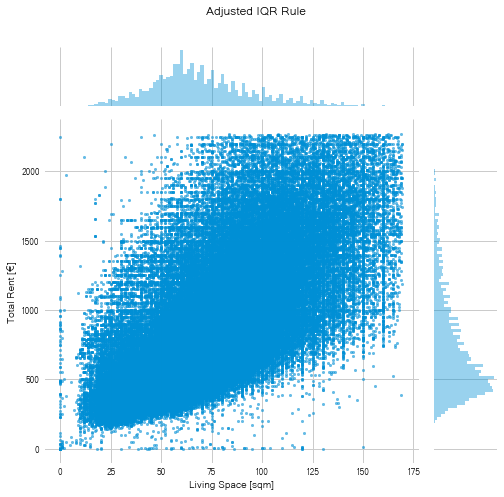

In [8]:
iqr_rule_25 = lambda x: iqr_rule(x, factor=2.5)
alrightish = iqr_rule_25(d["livingSpace"]) & iqr_rule_25(d["totalRent"])
g = sns.jointplot(x=d["livingSpace"][alrightish],y=d["totalRent"][alrightish],
              s=6, alpha=0.6, height=7, marginal_kws=dict(bins=100) )
g = g.ax_joint.set(xlabel="Living Space [sqm]", 
                    ylabel="Total Rent [€]")
plt.subplots_adjust(top=0.9)
plt.suptitle("Adjusted IQR Rule")
plt.show()

The plot has less data cut-off than before but there's still a rectangular border. Again, we could just keep on trying higher thresholds until we don't see the rectangular border anymore but there is problems with this approach. <br>
First, the method already didn't detect the flats of size 0 or of zero rent as outliers, increasing the threshold will certainly lead to more false negatives. <br>
The reason for this lies in the distribution of our data.
I added the histograms for each margin to get a look at the individual distributions and one can see that the distribution for the rent does not follow a normal distribution but is highly right-skewed. The living space distribution is also slightly right-skewed. <br>
Furthermore, we know that both rents and living space should only have values strictly above zero so it is probably more reasonable to model both variables assuming a log-normal distribution. 

Let's look at the whole data again but this time with log-transformed rent and living space:


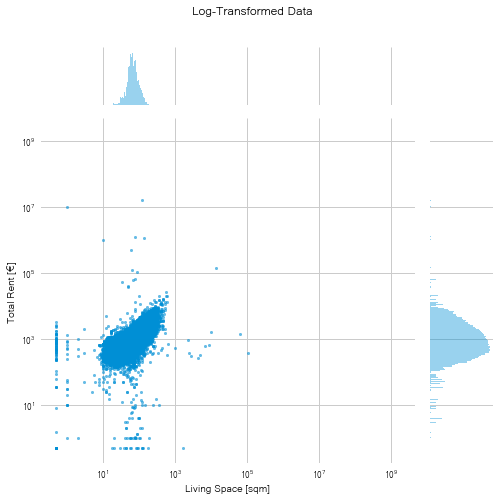

In [9]:
d["livingSpace_m"] =  np.where(d["livingSpace"] <= 0, 0.5, d["livingSpace"])
d["totalRent_m"] = np.where(d["totalRent"] <= 0, 0.5, d["totalRent"])
logbins=np.logspace(0,np.log(10e3),500)
g = sns.jointplot(x=d["livingSpace_m"],
                  y=d["totalRent_m"], 
                  s=6, alpha=0.6, height=7, 
                  marginal_kws=dict(bins=logbins)  )

g.ax_joint.set_yscale("log")
g.ax_joint.set_xscale("log")
g.ax_joint.set_xlabel("Living Space [sqm]")
g.ax_joint.set_ylabel("Total Rent [€]")
g.ax_marg_x.set_xscale("log")
g.ax_marg_y.set_xscale("log")
plt.subplots_adjust(top=0.9)
plt.suptitle("Log-Transformed Data")
plt.show()

Note that this is the same plot as our first one, just in log-scale. So only transforming the data already brought a big improvement.

Now using the IQR rule on the transformed data, we get the following result:


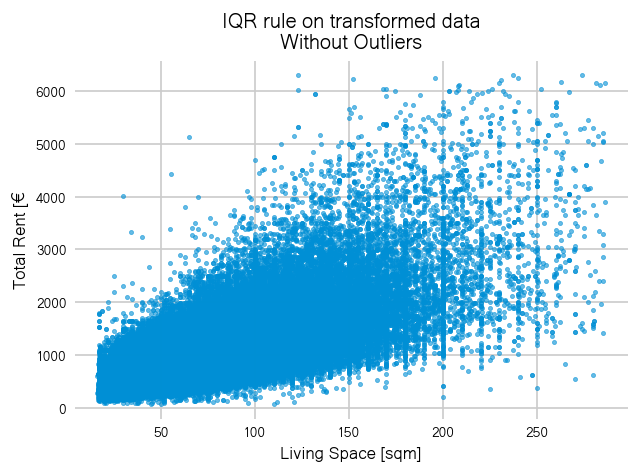

In [10]:
d["logRent"] = np.log(d["totalRent_m"])
d["logSpace"] = np.log(d["livingSpace_m"])

fig, ax  = plt.subplots(dpi=120)
alrightish = iqr_rule_25(d["logSpace"]) & iqr_rule_25(d["logRent"])
d["outlier"] = np.where(alrightish, "no_outlier", "outlier")

scatter = ax.scatter(d["livingSpace"][alrightish],
                    d["totalRent"][alrightish], 
                    s=6, alpha=0.6)

ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€")
ax.set_title("IQR rule on transformed data\nWithout Outliers")

plt.show()

Doesn't this already look much better? All zero-size and free-rent flats have been correctly detected as outliers while at the same time keeping more of the larger and more expensive flats.
While this plot is definitely an improvement to above, the rectangular borders are, unfortunately, still there.  <br>
Especially in the bottom left, there's a hard cut throwing away flats that are too small. The smallest place that is not considered an outlier has a size of 16.97sqm. As often with thresholds, it begs the question why a flat of size 16.97sqm is okay but the flats of size 16.6sqm are not. <br>
One problem is that the data also contains many shared flats. The size in the offer is then the size of the room but the rent is relatively high for such a small living area since one also pays for common areas in a shared flat.

To better understand which points where flagged as outliers, let's also plot all points again with outliers highlighted in red. To be able to see all points at once, I use log-scale again.

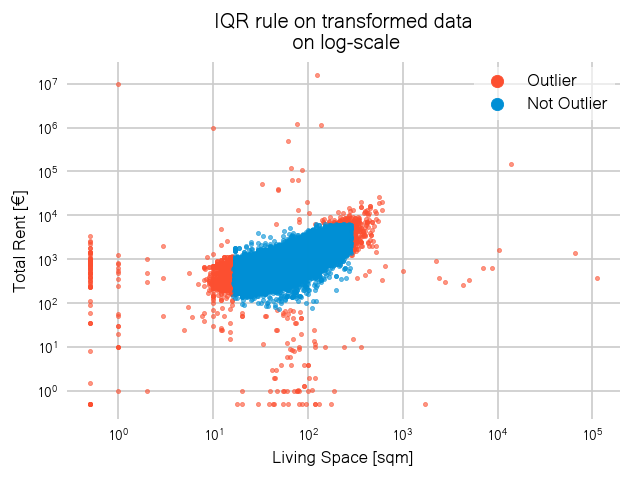

In [11]:
fig, ax  = plt.subplots(dpi=120)
sc = ax.scatter(x=d[d.outlier == "outlier"].livingSpace_m, 
              y=d[d.outlier == "outlier"].totalRent_m, 
              label="Outlier", s=6, c=red, alpha=0.6,)

sc = ax.scatter(x=d[d.outlier == "no_outlier"].livingSpace_m, 
              y=d[d.outlier == "no_outlier"].totalRent_m,
              label="Not Outlier", s=6, c=blue, alpha=0.6,)

ax.set_xlabel("Living Space [sqm]")
ax.set_ylabel("Total Rent [€]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title("IQR rule on transformed data\n on log-scale")
leg = ax.legend(markerscale=3)
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.show()


In total, around 1500 data points were classified as outliers. This sounds like a lot but is actually less than 1% of the total data.
We can now see that we not only lose data in the lower left corner but there's also a hard corner in the upper right. Again, one could increase the factor used in the IQR rule to get rid of the hard corners but this would eventually lead to the same problems as above. <br>
The problem with the IQR rule is that we apply it separately on each variable. In stats-speak this means we assume that our variables are independent of each other. Visually this means that the cut-off window is always rectangular. <br>
In this example though, the two variables are highly correlated and a rectangular window is thus not a good fit. Better would be to use an oval cut-off window.
Such an oval window can for example be obtained by using a multivariate Gaussian distribution. I will describe how we can use multivariate Gaussians, more specifically, Gaussian mixture methods, to detect outliers in the second part of this post. Stay tuned!

[Link](https://github.com/corriebar/blogdown_source/content/post/2020-02-17-outlier-handling-1.ipynb) to the jupyter notebook used to make this post.